In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from src.data_loading import DlDataset
from src.utils import plot_performance
from src.convnet import do_train_trials, train_net, evaluate_net_classes, NumNet, ModelPerformanceSummary

import matplotlib.pyplot as plt

In [5]:
# Not very elegant but removes all the warnings about deprecated upsample funtion
import warnings
warnings.filterwarnings("ignore")

# Training for the boolean target

In [6]:
#import data for a 1000 pairs
N = 1000
dataset = DlDataset(N, normalize=True, upsample=None)
datasetShape = list(dataset.__shape__()[1:])

** Model architectures **
Number of trainable paramaters should be below 100'000
1. 2 conv layers, 2 linear layers, no batch norm
2. 2 conv layers, 2 batch norm layers, 2 linear layers
3. 3 conv layers, 2 linear layers, no batch norm
4. 2 conv layers, 2 batch norm layers, 2 linear layers, 1 dropout layer

In [7]:
# The same net using NumNet class
# Dropout layer
# {'Type':'DropoutLayer', 'p':0.2}
models = []

# 2 convolutional layers followed by 2 linear layers
config_2c_2l = [{'Type': 'ConvLayer', 'out_channels':8, 'activation':'ReLU()', 'kernel_size':5},
          {'Type': 'ConvLayer', 'out_channels':16, 'activation':'ReLU()', 'kernel_size':3},
          {'Type': 'LinearLayer', 'out_features':32, 'activation':'ReLU()'},
          {'Type': 'LinearLayer', 'out_features':2}]
models.append(NumNet(datasetShape, config_2c_2l, name='2conv_2lin'))

# 2 convolutional layers followed by 2 linear layers with batch norm after each conv layer
config_2c_2l_2bn = [{'Type': 'ConvLayer', 'out_channels':8, 'activation':'ReLU()', 'kernel_size':5},
          {'Type': 'BatchNormLayer'},
          {'Type': 'ConvLayer', 'out_channels':16, 'activation':'ReLU()', 'kernel_size':3},
          {'Type': 'BatchNormLayer'},
          {'Type': 'LinearLayer', 'out_features':32, 'activation':'ReLU()'},
          {'Type': 'LinearLayer', 'out_features':2}]
models.append(NumNet(datasetShape, config_2c_2l_2bn, name='2conv_2lin_bnorm'))

# 3 convolutional layers followed by 2 linear layers
config_3c_2l = [{'Type': 'ConvLayer', 'out_channels':4, 'activation':'ReLU()', 'kernel_size':5},
          {'Type': 'ConvLayer', 'out_channels':8, 'activation':'ReLU()', 'kernel_size':3},
          {'Type': 'ConvLayer', 'out_channels':16, 'activation':'ReLU()', 'kernel_size':3},
          {'Type': 'LinearLayer', 'out_features':32, 'activation':'ReLU()'},
          {'Type': 'LinearLayer', 'out_features':2}]
models.append(NumNet(datasetShape, config_3c_2l, name='3conv_2lin'))

# 2 convolutional layers with batch norm and 1 maxpool, followed by 2 linear layers 
config_2c_2l_2bn_1do = [{'Type': 'ConvLayer', 'out_channels':32, 'activation':'ReLU()', 'kernel_size':5},
          {'Type': 'MaxPoolLayer', 'pooling':2, 'stride':2},
          {'Type': 'BatchNormLayer'},
          {'Type': 'DropoutLayer', 'p':0.5},
          {'Type': 'ConvLayer', 'out_channels':64, 'activation':'ReLU()', 'kernel_size':3},
          #{'Type': 'MaxPoolLayer', 'pooling':2, 'stride':2},
          {'Type': 'BatchNormLayer'},
          {'Type': 'LinearLayer', 'out_features':128, 'activation':'ReLU()'},
          #{'Type': 'DropoutLayer', 'p':0.5},
          {'Type': 'LinearLayer', 'out_features':2}]
models.append(NumNet(datasetShape, config_2c_2l_2bn_1do, name='2conv_2lin_2bn_1do'))

for model in models:
    model.summary()

 
Model '2conv_2lin'
Number              Layer               Input shape         Output shape        Trainable params    
0                   Conv2d              [2, 14, 14]         [8, 10, 10]         408
1                   Conv2d              [8, 10, 10]         [16, 8, 8]          1168
2                   Linear              1024                32                  32800
3                   Linear              32                  2                   66
----------------------------------------------------------------------------------------------------
Total number of trainable parameters: 34442
----------------------------------------------------------------------------------------------------
 
Model '2conv_2lin_bnorm'
Number              Layer               Input shape         Output shape        Trainable params    
0                   Conv2d              [2, 14, 14]         [8, 10, 10]         408
1                   BatchNorm2d         [8, 10, 10]         [8, 10, 10]         16

In [8]:
# Train parameter
epochs = 6
eta = 5e-2
lambda_l2 = 1e-3
gamma = 0.2
depth = 4
n_filters = 3
batch_spec = {'batch_size':4, 'shuffle':True, 'num_workers':4}

device = torch.device('cpu') #Hannes' gpu is not supported but has cuda cores... 
criterion = torch.nn.CrossEntropyLoss()

# Prepare dataloader£
dataloader = []
for mode in ['train','test']:
    if mode == 'train':
        dataset.train()
    elif mode == 'test':
        dataset.test()
    dataloader.append(dataset.return_dataloader(**batch_spec))


** A single training run using the 'train_net' function: **

In [9]:
# Train each model with the same parameters
perf_summary = []
for model in models[1:3]:
    print("-"*100)
    print("Running model: {}".format(model.name()))
    print("-"*100)
    optim = torch.optim.SGD(model.parameters(), lr=eta, momentum=gamma)
    #optim = torch.optim.Adam(model.parameters(), lr=0.001)
    performance, model = train_net(model, device, optim, criterion, dataloader,
                                    epochs=epochs, lambda_=1e-3, reg_type=None, 
                                    save=False)
    perf_summary.append(ModelPerformanceSummary(model, performance))

----------------------------------------------------------------------------------------------------
Running model: 2conv_2lin_bnorm
----------------------------------------------------------------------------------------------------
Epoch 0: Duration: 9.18s, Train Loss: 1.47e-01, Train Acc: 0.71, Val Loss: 1.14e-01, Val Acc: 0.77
Epoch 1: Duration: 9.20s, Train Loss: 1.15e-01, Train Acc: 0.79, Val Loss: 8.70e-02, Val Acc: 0.83
Epoch 2: Duration: 9.02s, Train Loss: 9.59e-02, Train Acc: 0.84, Val Loss: 7.53e-02, Val Acc: 0.88
Epoch 3: Duration: 9.76s, Train Loss: 8.22e-02, Train Acc: 0.85, Val Loss: 6.14e-02, Val Acc: 0.91
Epoch 4: Duration: 10.32s, Train Loss: 6.67e-02, Train Acc: 0.88, Val Loss: 5.84e-02, Val Acc: 0.92
Epoch 5: Duration: 10.10s, Train Loss: 5.47e-02, Train Acc: 0.91, Val Loss: 3.99e-02, Val Acc: 0.93
----------------------------------------------------------------------------------------------------
Running model: 3conv_2lin
-------------------------------------------

Model: 2conv_2lin_bnorm      train_loss           min: 0.055 max: 0.147
Model: 2conv_2lin_bnorm      test_loss            min: 0.040 max: 0.114
Model: 2conv_2lin_bnorm      train_accuracy       min: 0.714 max: 0.913
Model: 2conv_2lin_bnorm      test_accuracy        min: 0.774 max: 0.933
Model: 3conv_2lin            train_loss           min:   nan max:   nan
Model: 3conv_2lin            test_loss            min:   nan max:   nan
Model: 3conv_2lin            train_accuracy       min: 0.474 max: 0.483
Model: 3conv_2lin            test_accuracy        min: 0.474 max: 0.474


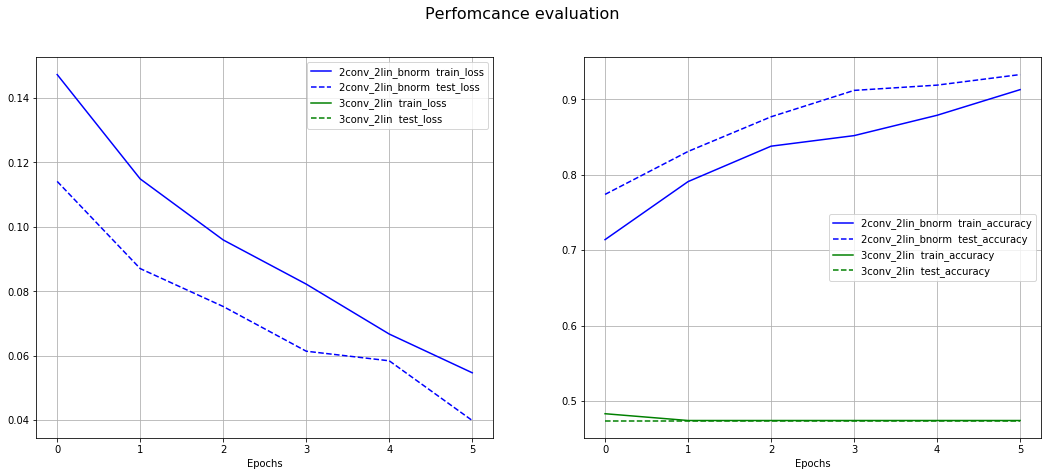

In [15]:
# Plot stuff
axes, extrema = plot_performance(perf_summary, [['train_loss','test_loss'],['train_accuracy','test_accuracy']], suptitle='Perfomcance evaluation')

In [ ]:
dataset.test()
dataset.infere(models[3],5);
dataset.infere(models[3],6);

** Multiple training trials using the 'do_train_trials' function: **

In [16]:
trial_summaries = []
for model in models[1:3]:
    print("-"*100)
    print("Running model: {}".format(model.name()))
    print("-"*100)
    optim_spec = {'type':'SGD', 'lr':eta, 'momentum':gamma}
    batch_spec = {'batch_size': 100, 'shuffle':True, 'num_workers':4}
    
    performance = do_train_trials(3, model, device, optim_spec, criterion, dataset, batch_spec,
                                    epochs=epochs, lambda_=1e-3, reg_type=None, 
                                    save=False)
    trial_summaries.append(performance)

----------------------------------------------------------------------------------------------------
Running model: 2conv_2lin_bnorm
----------------------------------------------------------------------------------------------------
Epoch 0: Duration: 8.75s, Train Loss: 7.09e-03, Train Acc: 0.59, Val Loss: 5.59e-03, Val Acc: 0.75
Epoch 1: Duration: 8.64s, Train Loss: 5.07e-03, Train Acc: 0.76, Val Loss: 4.55e-03, Val Acc: 0.82
Epoch 2: Duration: 9.01s, Train Loss: 4.24e-03, Train Acc: 0.81, Val Loss: 3.81e-03, Val Acc: 0.86
Epoch 3: Duration: 8.93s, Train Loss: 3.67e-03, Train Acc: 0.86, Val Loss: 3.13e-03, Val Acc: 0.90
Epoch 4: Duration: 9.35s, Train Loss: 3.22e-03, Train Acc: 0.89, Val Loss: 2.74e-03, Val Acc: 0.92
Epoch 5: Duration: 9.03s, Train Loss: 2.83e-03, Train Acc: 0.91, Val Loss: 2.41e-03, Val Acc: 0.93
Epoch 0: Duration: 9.06s, Train Loss: 6.84e-03, Train Acc: 0.59, Val Loss: 6.03e-03, Val Acc: 0.64
Epoch 1: Duration: 8.99s, Train Loss: 4.90e-03, Train Acc: 0.78, Val Loss

Model: 2conv_2lin_bnorm      avg_train_loss       min: 0.003 max: 0.007
Model: 2conv_2lin_bnorm      avg_test_loss        min: 0.002 max: 0.006
Model: 2conv_2lin_bnorm      avg_train_accuracy   min: 0.597 max: 0.902
Model: 2conv_2lin_bnorm      avg_test_accuracy    min: 0.695 max: 0.934
Model: 3conv_2lin            avg_train_loss       min:   nan max:   nan
Model: 3conv_2lin            avg_test_loss        min:   nan max:   nan
Model: 3conv_2lin            avg_train_accuracy   min: 0.459 max: 0.459
Model: 3conv_2lin            avg_test_accuracy    min: 0.459 max: 0.459


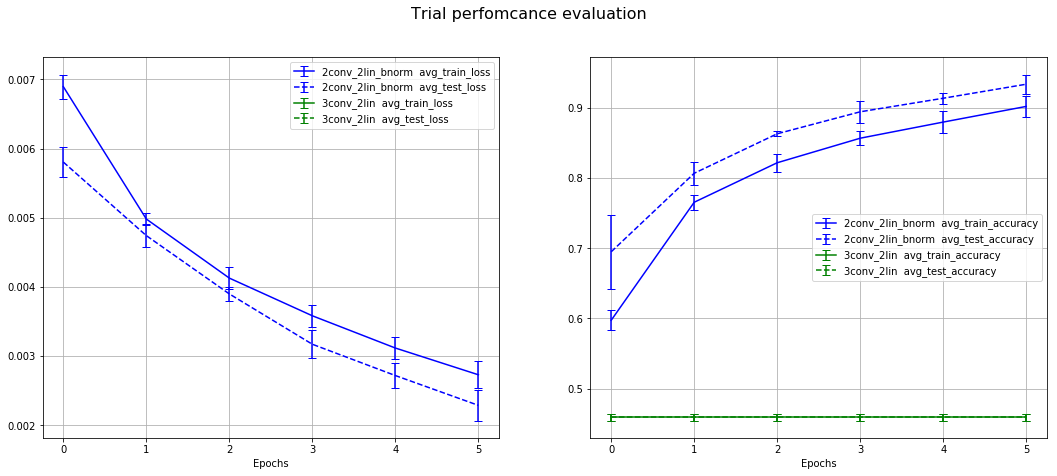

In [23]:
# Plot stuff
plot_this = [[('avg_train_loss','std_train_loss'),('avg_test_loss','std_test_loss')], \
             [('avg_train_accuracy','std_train_accuracy'),('avg_test_accuracy','std_test_accuracy')]]
axes, extrema = plot_performance(trial_summaries, plot_this, suptitle='Trial perfomcance evaluation')

# Training for the digit classes

In [ ]:
# Train for classes and not the target.

dataset_train_classes = DlDataset(N, normalize=True, upsample=None, split_dataset = True)

dataset_test_classes = DlDataset(N, normalize=True, upsample=None, split_dataset = True)

dataset_train_classes.train()
dataset_test_classes.test()


datasetShape_classes = list(dataset_train_classes.__shape__()[1:])

In [ ]:
# The same net using NumNet class
# Dropout layer
# {'Type':'DropoutLayer', 'p':0.2}
models = []

# 2 convolutional layers followed by 2 linear layers
config_2c_2l = [{'Type': 'ConvLayer', 'out_channels':8, 'activation':'ReLU()', 'kernel_size':5},
          {'Type': 'ConvLayer', 'out_channels':16, 'activation':'ReLU()', 'kernel_size':3},
          {'Type': 'LinearLayer', 'out_features':32, 'activation':'ReLU()'},
          {'Type': 'LinearLayer', 'out_features':10}]
models.append(NumNet(datasetShape_classes, config_2c_2l, name='2conv_2lin'))

# 2 convolutional layers followed by 2 linear layers with batch norm after each conv layer
config_2c_2l_2bn = [{'Type': 'ConvLayer', 'out_channels':8, 'activation':'ReLU()', 'kernel_size':5},
          {'Type': 'BatchNormLayer'},
          {'Type': 'ConvLayer', 'out_channels':16, 'activation':'ReLU()', 'kernel_size':3},
          {'Type': 'BatchNormLayer'},
          {'Type': 'LinearLayer', 'out_features':32, 'activation':'ReLU()'},
          {'Type': 'LinearLayer', 'out_features':10}]
models.append(NumNet(datasetShape_classes, config_2c_2l_2bn, name='2conv_2lin_2bn'))

# 3 convolutional layers followed by 2 linear layers
config_3c_2l = [{'Type': 'ConvLayer', 'out_channels':4, 'activation':'ReLU()', 'kernel_size':5},
          {'Type': 'ConvLayer', 'out_channels':8, 'activation':'ReLU()', 'kernel_size':3},
          {'Type': 'ConvLayer', 'out_channels':16, 'activation':'ReLU()', 'kernel_size':3},
          {'Type': 'LinearLayer', 'out_features':32, 'activation':'ReLU()'},
          {'Type': 'LinearLayer', 'out_features':10}]
models.append(NumNet(datasetShape_classes, config_3c_2l, name='3conv_2lin'))

# 2 convolutional layers with batch norm and 1 maxpool, followed by 2 linear layers 
config_2c_2l_2bn_1do = [{'Type': 'ConvLayer', 'out_channels':32, 'activation':'ReLU()', 'kernel_size':5},
          {'Type': 'MaxPoolLayer', 'pooling':2, 'stride':2},
          {'Type': 'BatchNormLayer'},
          {'Type': 'DropoutLayer', 'p':0.5},
          {'Type': 'ConvLayer', 'out_channels':64, 'activation':'ReLU()', 'kernel_size':3},
          #{'Type': 'MaxPoolLayer', 'pooling':2, 'stride':2},
          {'Type': 'BatchNormLayer'},
          {'Type': 'LinearLayer', 'out_features':128, 'activation':'ReLU()'},
          #{'Type': 'DropoutLayer', 'p':0.5},
          {'Type': 'LinearLayer', 'out_features':10}]
models.append(NumNet(datasetShape_classes, config_2c_2l_2bn_1do, name='2conv_2lin_2bn_1do'))

for model in models:
    model.summary()

In [ ]:
# Train parameter
epochs = 30
mini_batch_size = 100
eta = 5e-2
lambda_l2 = 1e-3
gamma = 0.2
depth = 4
n_filters = 3

device = torch.device('cpu') #Hannes' gpu is not supported but has cuda cores... 

criterion = torch.nn.CrossEntropyLoss()
dataloader = []
dataloader.append(DataLoader(dataset_train_classes, batch_size=mini_batch_size,shuffle=True, num_workers=4))
dataloader.append(DataLoader(dataset_test_classes, batch_size=mini_batch_size,shuffle=True, num_workers=4))

In [ ]:
# Train each model with the same parameters
perf_summary = []
for model in models:
    print("-"*100)
    print("Running model: {}".format(model.name()))
    print("-"*100)
    optim = torch.optim.SGD(model.parameters(), lr=eta, momentum=gamma)
    #optim = torch.optim.Adam(model.parameters(), lr=0.001)
    performance, model = train_net(model, device, optim, criterion, dataloader,
                                    epochs=epochs, lambda_=1e-3, reg_type=None, 
                                    save=False)
    perf_summary.append(ModelPerformanceSummary(model, performance))

In [ ]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
fig = plt.figure('History Plot', figsize=(18,7))
fig.suptitle('Performance of Networks', fontsize=16)

ax1 = fig.add_subplot(121)

for i,mod_perf in enumerate(perf_summary):
    model_name = mod_perf.model.name()
    avg_loss_train = mod_perf.get_performance('train_loss')
    avg_loss_test = mod_perf.get_performance('test_loss')
    ax1.set_title('Error')
    ax1.plot(range(0,epochs), avg_loss_train, linestyle='-', color=colors[i%8], label = model_name + ' train')
    ax1.plot(range(0,epochs), avg_loss_test, linestyle='--', color=colors[i%8], label = model_name + ' valid.')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Cross Entropy Loss')
ax1.grid()
ax1.legend()

ax2 = fig.add_subplot(122)

for i,mod_perf in enumerate(perf_summary):
    model_name = mod_perf.model.name()
    avg_acc_train = mod_perf.get_performance('train_accuracy')
    avg_acc_test = mod_perf.get_performance('test_accuracy')
    ax2.set_title('Accuracy')
    ax2.plot(range(0,epochs), avg_acc_train, linestyle='-', color=colors[i%8], label = model_name + ' train')
    ax2.plot(range(0,epochs), avg_acc_test, linestyle='--', color=colors[i%8], label = model_name + ' valid.')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy [% correct]')
    print('Model: {:<20} max Test Acc: {:>5.3f}'.format(model_name, max(avg_acc_test)))
ax2.grid()
ax2.legend();

## Evaluating target boolean

In [ ]:
target_accuracy = []
for model in models:
    target_accuracy.append(evaluate_net_classes(model,dataset_test_classes))
    print('Model: {:<20} Target Acc: {:>5.3f}'.format(model.name(), target_accuracy[-1]))


In [ ]:
dataset_test_classes.selectSplittedDataset('left')
pred_1, classes_1, target_1 = dataset_test_classes.infere(models[3],10);

dataset_test_classes.selectSplittedDataset('right')
pred_2, classes_2, target_2 = dataset_test_classes.infere(models[3],10);
print("Real Target is: {}".format(target_1))
print("Predicted Target is: {}".format((pred_1 <= pred_2).item()))